### Simple Recommenders

Her kullanıcı için film popülerliğine ve/veya türüne göre genelleştirilmiş önerilerde bulunur. Bu sistemin arkasındaki temel fikir daha popüler ve eleştirmenlerce beğenilen filmlerin , ortalama kitle tarafından beğenilme olasılığının yüksek olmasıdır.

Örnek olarak IMDB'den toplanan meta verileri kullanılarak basitleştirilmiş bir IMDB Top 250 film klonu oluşturulacaktır.

Adımlar:

#### Filmleri derecelendirmek için metriğe veya skora karar verilmesi
#### Her film için skorun hesaplanması
#### Filmlerin skora göre sıralanması ve en iyi sonuçların elde edilmesi.

In [ ]:
#Gerekli kütüphaneleri ekleyelim.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install missingno

  Using cached missingno-0.5.0-py3-none-any.whl (8.8 kB)


In [4]:
from tqdm import tqdm
import warnings
from ast import literal_eval
import missingno as msno
warnings.filterwarnings("ignore")


In [5]:
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer


In [7]:
metadata = pd.read_csv("archive/movies_metadata.csv",low_memory = False)

In [8]:
metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [9]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

45466 veri bulunmakta ve  24 öznitelikten oluşmaktadır. Eksik gözlem de vardır.


#### Eksik Verileri Gözlemleme

<AxesSubplot:>

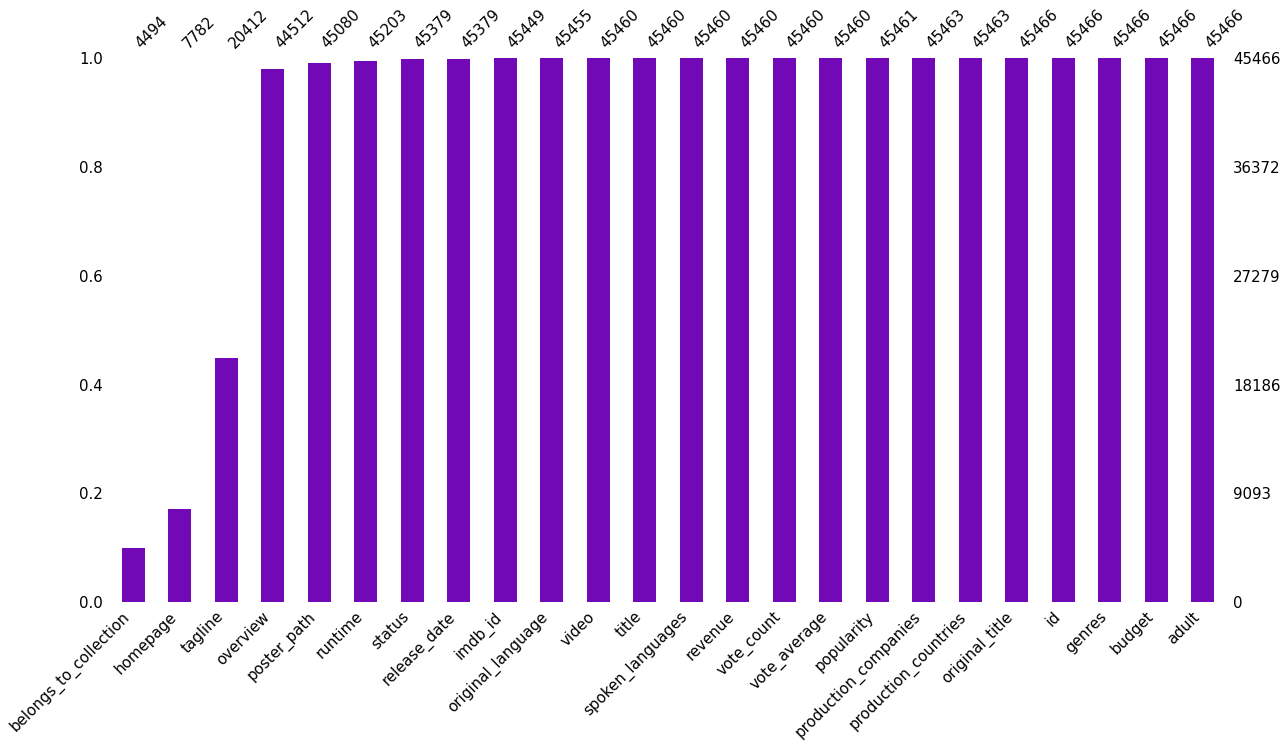

In [10]:
msno.bar(metadata, sort="ascending", color="#7209b7", figsize = (20,10), fontsize = 15)

In [11]:
metadata.shape

(45466, 24)

In [12]:
metadata.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [18]:
#pd.DataFrame(metadata.isnull().sum()/metadata.shape[0]*100)

Düşünülen en temel metriklerden biri derecelendirmedir. Ancak bu metriği kullanmanın bazı sakıncaları vardır.Birincisi filmin popülerliğini dikkate almaz. Bu nedenle 10 seçmenden 9 puan alan bir film, 10000 seçmenden 8.9 puan alan bir filmden daha iyi sayılacak. Ayrıca bu metrik son derece yüksek puanlarla daha az sayıda seçmen bulunan filmleri tercih etme eğiliminde olacaktır. Seçmen sayısı arttıkça Bir filmin derecelendirilmesi, filmin kalitesini yansıtan bir değere doğru düzenli olarak yaklaşır. Bir filmin kalitesini az sayıda seçmenle belirlemek zordur.

Bu eksiklikler dikkate alınarak, ortalama dereceyi ve alınan oyların sayısını dikkate alan 'ağırlıklı bir derecelendirme notu' getirmek gerekir. Böyle bir sistem 100000 seçmenden 9 puan almış bir filmin, aynı derecelendirmeye sahip ancak birkaç yüz seçmene sahip bir YouTube web serisinden daha yüksek puan almasını sağlayacaktır.

IMDB'nin Top 250 klonu oluşturulacağı için ağırlıklı derecelendirme formülü kullanılacaktır.

###  Weighted Rating (WR) = (v/(v+m).R)+(m/(v+m).C)
v->Filmin oy sayısı
m->Tabloda listelenmesi gereken asgari oy
R->Filmin ortalama derecesi
C->Raporun tamamındaki ortalama oylama

Verisetinde her film için V(vote_count) ve R(vote_average) değerleri zaten var. C değerini de doğrudan hesaplamak mümkündür. Belirlenmesi gereken m değeri için ise doğru bir değer yoktur. Bu değer belirli bir sayıdan az oy almış filmleri yok sayan bir filtre olarak düşünülebilir. Değeri tercihe bağlıdır.

Bu durumda 90'lık persentif kesilme olarak kullanılacaktır. Yani grafikte yer alan bir film, listedeki filmlerin en az %90'ından daha fazla oy almalıdır.

İlk olarak, tüm filmlerin ortalama dereceleri(C) hesaplanır.

In [14]:
#Filmlerin ortalama derecesinin (C) hesaplanması

In [15]:
metadata["vote_average"].mean()

5.618207215133889

In [39]:
C = metadata.vote_average.mean()

In [40]:
C

5.618207215133889

In [41]:
metadata["vote_average"].head(5)

0    7.7
1    6.9
2    6.5
3    6.1
4    5.7
Name: vote_average, dtype: float64

In [42]:
metadata["vote_average"].unique

<bound method Series.unique of 0        7.7
1        6.9
2        6.5
3        6.1
4        5.7
        ... 
45461    4.0
45462    9.0
45463    3.8
45464    0.0
45465    0.0
Name: vote_average, Length: 45466, dtype: float64>

In [43]:
metadata["vote_count"]

0        5415.0
1        2413.0
2          92.0
3          34.0
4         173.0
          ...  
45461       1.0
45462       3.0
45463       6.0
45464       0.0
45465       0.0
Name: vote_count, Length: 45466, dtype: float64

In [44]:
metadata["vote_count"].unique

<bound method Series.unique of 0        5415.0
1        2413.0
2          92.0
3          34.0
4         173.0
          ...  
45461       1.0
45462       3.0
45463       6.0
45464       0.0
45465       0.0
Name: vote_count, Length: 45466, dtype: float64>

m değerinin 90 persentif olarak hesaplanması için pandas kütüphanesi ve .quantile() metodu kullanılır.

In [45]:
#En az alınabilecek oy sayısı(m) hesaplanması

In [46]:
 m  = metadata["vote_count"].quantile(0.90)

In [47]:
m

160.0

Ardından oylama sayılarına bağlı olarak grafik için uygun filmler filtrelenir.

In [48]:
#Filmlerin Filtrelenmesi
q_movies = metadata.copy().loc[metadata['vote_count'] >= m]

.copy() ile yeni q_movies DataFrame'i oluşturulup filtrelenen filmler bu DataFrame'e aktarıldı ki orjinal metadata verileri etkilenmesin.

In [49]:
q_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4555 entries, 0 to 45343
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  4555 non-null   object 
 1   belongs_to_collection  1261 non-null   object 
 2   budget                 4555 non-null   object 
 3   genres                 4555 non-null   object 
 4   homepage               1831 non-null   object 
 5   id                     4555 non-null   object 
 6   imdb_id                4555 non-null   object 
 7   original_language      4555 non-null   object 
 8   original_title         4555 non-null   object 
 9   overview               4550 non-null   object 
 10  popularity             4555 non-null   object 
 11  poster_path            4555 non-null   object 
 12  production_companies   4555 non-null   object 
 13  production_countries   4555 non-null   object 
 14  release_date           4555 non-null   object 
 15  rev

Şimdi her film için metriğin hesaplanması gerekiyor. Bunun için weight_rating() fonksiyonu tanımlanıp, filmler için yeni bir özellik (score) tanımlanacaktır.

In [52]:
def weighted_rating(x,m=m,C=C):
    v = x["vote_count"]
    R = x["vote_average"]
    return (v/(v+m)*R)+(m/(v+m)* C)

In [53]:
#score değeri oluşturulur. weighted_rating() fonksiyonu ile değeri hesaplanır ve atanır.
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

Son olarak, DataFrame'in score özelliğine göre sıralanması ve en iyi 15 filmin başlığının, oy sayısının, oy oranının ve ağırlıklı puanının gösterilmesi.

In [54]:
#Filmlerin sıralanması
q_movies = q_movies.sort_values("score",ascending=False)

In [56]:
#En iyi 15 filmin listelenmesi
print(q_movies[['title','vote_count','vote_average','score']].head(15))

                                 title  vote_count  vote_average     score
314           The Shawshank Redemption      8358.0           8.5  8.445869
834                      The Godfather      6024.0           8.5  8.425439
10309      Dilwale Dulhania Le Jayenge       661.0           9.1  8.421453
12481                  The Dark Knight     12269.0           8.3  8.265477
2843                        Fight Club      9678.0           8.3  8.256385
292                       Pulp Fiction      8670.0           8.3  8.251406
522                   Schindler's List      4436.0           8.3  8.206639
23673                         Whiplash      4376.0           8.3  8.205404
5481                     Spirited Away      3968.0           8.3  8.196055
2211                 Life Is Beautiful      3643.0           8.3  8.187171
1178            The Godfather: Part II      3418.0           8.3  8.180076
1152   One Flew Over the Cuckoo's Nest      3001.0           8.3  8.164256
351                      